# Artificial Neural Networks and Deep Learning

---

## Homework 1: Minimal Working Example

To make your first submission, follow these steps:
1. Create a folder named `[2024-2025] AN2DL/Homework 1` in your Google Drive.
2. Upload the `training_set.npz` file to this folder.
3. Upload the Jupyter notebook `Homework 1 - Minimal Working Example.ipynb`.
4. Load and process the data.
5. Implement and train your model.
6. Submit the generated `.zip` file to Codabench.


## 🌐 Connect Colab to Google Drive

In [1]:
#from google.colab import drive

#drive.mount('/gdrive')
#%cd /gdrive/My Drive/[2024-2025] AN2DL/Homework 1

## ⚙️ Import Libraries

In [ ]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
import keras as tfk
from keras import layers as tfkl
from keras.preprocessing import image
from keras.applications import EfficientNetB0
from keras.applications.EfficientNetB0 import preprocess_input


# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
from PIL import Image
import matplotlib.gridspec as gridspec

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

print(f"Tensorflow version -> {tf.__version__}")
print(f"Keras version -> {tfk.__version__}")
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


2.17.0
Tensorflow version -> 2.17.0
Keras version -> 3.4.1
Num GPUs Available:  1


I0000 00:00:1731624896.022680   12299 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1731624896.047997   12299 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1731624896.048036   12299 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


## ⏳ Load the Data

In [3]:
data = np.load('training_set.npz')

images = data["images"]
labels = data["labels"]



X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.25, random_state=42)

# Normalize data to the range [0, 1]
X_train = (X_train / 255).astype('float32')
X_test = (X_test / 255).astype('float32')

# Convert labels to categorical format using one-hot encoding
y_train = tfk.utils.to_categorical(y_train)
y_test = tfk.utils.to_categorical(y_test)



## ⏳ Inspect Data

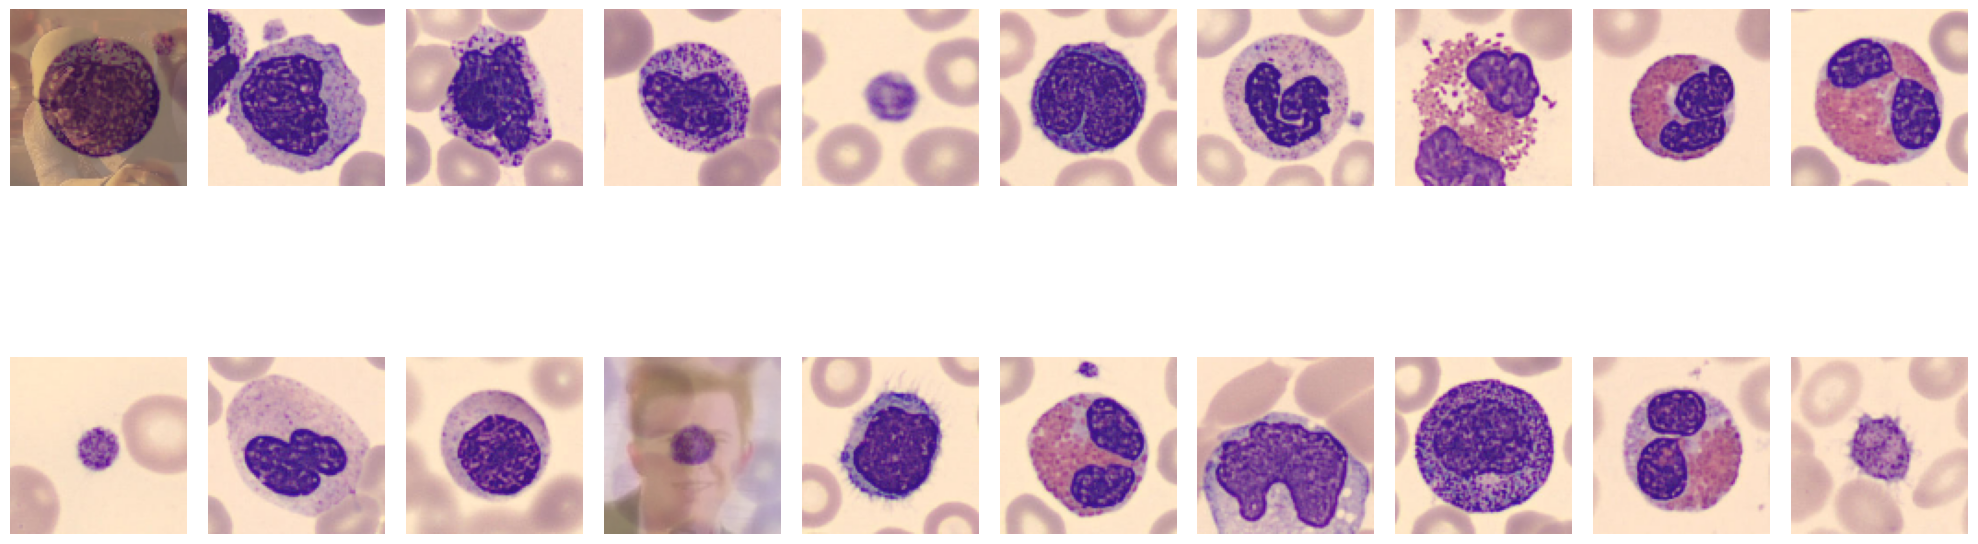

In [35]:

# Número de imágenes a mostrar
num_img = 20

# Selecciona 10 índices aleatorios
random_indices = np.random.choice(len(images), num_img, replace=False)

# Crear subplots para mostrar las imágenes
fig, axes = plt.subplots(2, num_img // 2, figsize=(20, 9))

for i, idx in enumerate(random_indices):
    ax = axes[i // (num_img // 2), i % (num_img // 2)]
    ax.imshow(np.clip(images[idx], 0, 255).astype(np.uint8))  # Convertir a uint8 para mostrar correctamente
    ax.set_xlabel(f"Label: {labels[idx]}")
    ax.axis('off')  # Opcional: Ocultar los ejes

plt.tight_layout()
plt.show()

## Delete Rickrolls

In [ ]:
# Cargar el modelo sin la capa final para usar como extractor de características
model = EfficientNetB0(weights='imagenet', include_top=False, pooling='avg', input_shape=(93, 93, 3))


# Función para obtener las características de una imagen
def get_features(img_path):
    img = image.load_img(img_path, target_size=(299, 299))  # InceptionV3 usa tamaño 299x299
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    features = model.predict(img_array)
    return features

## 🧮 Define Network Parameters

In [5]:
# Number of training epochs
epochs = 1000

# Batch size for training
batch_size = 32

# Learning rate: step size for updating the model's weights
learning_rate = 0.001

## 🛠️ Define the Model

In [6]:
def build_model(
    input_shape=(96,96,3),
    output_shape=8,
    learning_rate=learning_rate,
    augmentation=None,
    seed=seed
):
    # Set the random seed for reproducibility
    tf.random.set_seed(seed)

    # Define the input layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Apply optional data augmentation, then first convolutional layer
    if augmentation == None:
        x = tfkl.Conv2D(filters=16, kernel_size=3, padding='same', name='conv0')(input_layer)
    else:
        x = augmentation(input_layer)
        x = tfkl.Conv2D(filters=16, kernel_size=3, padding='same', name='conv0')(x)

    # Apply activation and pooling after the first convolution
    x = tfkl.ReLU(name='relu0')(x)
    x = tfkl.MaxPooling2D(name='mp0')(x)

    # Apply second convolutional layer, activation, and pooling
    x = tfkl.Conv2D(filters=32, kernel_size=3, padding='same', name='conv1')(x)
    x = tfkl.ReLU(name='relu1')(x)
    x = tfkl.MaxPooling2D(name='mp1')(x)

    # Apply third convolutional layer, activation, and pooling
    x = tfkl.Conv2D(filters=64, kernel_size=3, padding='same', name='conv2')(x)
    x = tfkl.ReLU(name='relu2')(x)
    x = tfkl.MaxPooling2D(name='mp2')(x)

    # Apply fourth convolutional layer, activation, and pooling
    x = tfkl.Conv2D(filters=128, kernel_size=3, padding='same', name='conv3')(x)
    x = tfkl.ReLU(name='relu3')(x)
    x = tfkl.MaxPooling2D(name='mp3')(x)

    # Apply fifth convolutional layer, activation, and pooling
    x = tfkl.Conv2D(filters=256, kernel_size=3, padding='same', name='conv4')(x)
    x = tfkl.ReLU(name='relu4')(x)
    x = tfkl.Flatten(name='flatten')(x)

    # Define the output layer with softmax activation for classification
    output_layer = tfkl.Dense(units=y_train.shape[1], activation='softmax', name='Output')(x)

    # Create the model
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='CNN')

    # Compile the model with categorical crossentropy loss and Adam optimizer
    loss = tfk.losses.CategoricalCrossentropy()
    optimizer = tfk.optimizers.Adam(learning_rate)
    metrics = ['accuracy']
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

    # Return the compiled model
    return model

# Build the model with specified input and output shapes
model = build_model()

# Display a summary of the model architecture
model.summary(expand_nested=True, show_trainable=True)

# Plot the model architecture
tfk.utils.plot_model(model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

I0000 00:00:1731624898.886831   12299 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1731624898.886887   12299 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1731624898.886900   12299 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1731624899.055903   12299 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1731624899.055958   12299 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

Model: "CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ Input (InputLayer)          │ (None, 96, 96, 3)     │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv0 (Conv2D)              │ (None, 96, 96, 16)    │        448 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ relu0 (ReLU)                │ (None, 96, 96, 16)    │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ mp0 (MaxPooling2D)          │ (None, 48, 48, 16)    │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv1 (Conv2D)              │ (None, 48, 48, 32)    │      4,640 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ relu1 (ReLU)                │ (None, 48, 48, 32)    │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ mp1 (MaxPooling2D)          │ (None, 24, 24, 32)    │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv2 (Conv2D)              │ (None, 24, 24, 64)    │     18,496 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ relu2 (ReLU)                │ (None, 24, 24, 64)    │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ mp2 (MaxPooling2D)          │ (None, 12, 12, 64)    │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv3 (Conv2D)              │ (None, 12, 12, 128)   │     73,856 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ relu3 (ReLU)                │ (None, 12, 12, 128)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ mp3 (MaxPooling2D)          │ (None, 6, 6, 128)     │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv4 (Conv2D)              │ (None, 6, 6, 256)     │    295,168 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ relu4 (ReLU)                │ (None, 6, 6, 256)     │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ flatten (Flatten)           │ (None, 9216)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ Output (Dense)              │ (None, 8)             │     73,736 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 466,344 (1.78 MB)

 Trainable params: 466,344 (1.78 MB)

 Non-trainable params: 0 (0.00 B)

You must install pydot (`pip install pydot`) for `plot_model` to work.


## 🧠 Train the Model

In [7]:
# Define the patience value for early stopping
patience = 100

# Create an EarlyStopping callback
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=patience,
    restore_best_weights=True
)

# Store the callback in a list
callbacks = [early_stopping]

In [8]:
# Define a data augmentation pipeline with random flip, brightness, and translation
augmentation = tfk.Sequential([
    tfkl.RandomFlip("horizontal"),
    tfkl.RandomBrightness(0.2, value_range=(0,1)),
    tfkl.RandomTranslation(0.2,0.2),
], name='preprocessing')

# Build the model with specified input and output shapes
model = build_model(augmentation=augmentation)

# Train the model with early stopping callback
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_test, y_test),
    callbacks=callbacks
).history

# Calculate and print the final validation accuracy
final_val_accuracy = round(max(history['val_accuracy'])* 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')



# Save the trained model to a file with the accuracy included in the filename
model_filename = 'weights.keras'
model.save(model_filename)

# Delete the model to free up resources
del model

Epoch 1/1000


W0000 00:00:1731624901.248342   12465 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731624901.267402   12465 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731624901.268462   12465 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731624901.270084   12465 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731624901.275949   12465 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731624901.276806   12465 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731624901.277471   12465 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731624901.278184   12465 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731624901.290892   12465 gp

 13/323 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.1463 - loss: 2.0670

W0000 00:00:1731624901.887907   12465 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731624901.889465   12465 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731624901.890670   12465 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731624901.893243   12465 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731624901.894140   12465 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731624901.895005   12465 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731624901.895925   12465 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731624901.915203   12465 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731624901.915912   12465 gp

318/323 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3023 - loss: 1.7768

W0000 00:00:1731624904.741606   12466 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731624904.742255   12466 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731624904.742739   12466 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731624904.743208   12466 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731624904.743655   12466 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731624904.744225   12466 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731624904.744697   12466 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731624904.745200   12466 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731624904.745691   12466 gp

323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3035 - loss: 1.7741

W0000 00:00:1731624904.946333   12466 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731624904.946898   12466 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731624904.947303   12466 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731624904.947701   12466 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731624904.948158   12466 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731624904.948576   12466 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731624904.949028   12466 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731624904.949453   12466 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731624904.949926   12466 gp

323/323 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.3037 - loss: 1.7736 - val_accuracy: 0.5613 - val_loss: 1.1581
Epoch 2/1000
  6/323 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.4826 - loss: 1.1841

W0000 00:00:1731624905.775531   12467 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731624905.776095   12467 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731624905.776456   12467 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731624905.776864   12467 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731624905.777213   12467 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731624905.777559   12467 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731624905.778011   12467 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731624905.778479   12467 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731624905.778960   12467 gp

323/323 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5632 - loss: 1.0847 - val_accuracy: 0.7038 - val_loss: 0.7756
Epoch 3/1000
323/323 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.6666 - loss: 0.8536 - val_accuracy: 0.7372 - val_loss: 0.6372
Epoch 4/1000
323/323 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.7280 - loss: 0.7008 - val_accuracy: 0.7971 - val_loss: 0.5158
Epoch 5/1000
323/323 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7767 - loss: 0.5856 - val_accuracy: 0.8110 - val_loss: 0.4761
Epoch 6/1000
323/323 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8004 - loss: 0.5287 - val_accuracy: 0.8369 - val_loss: 0.4330
Epoch 7/1000
323/323 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8108 - loss: 0.4789 - val_accuracy: 0.8526 - val_loss: 0.3714
Epoch 8/1000
323/323 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8260 - loss: 0.4548 - val_accuracy: 0.8523 - val_loss: 0.3635
Epoch 9/1000
323/323 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8260 - loss: 0.4448 - val_acc

KeyboardInterrupt: 

## Plot

89.32
88.25


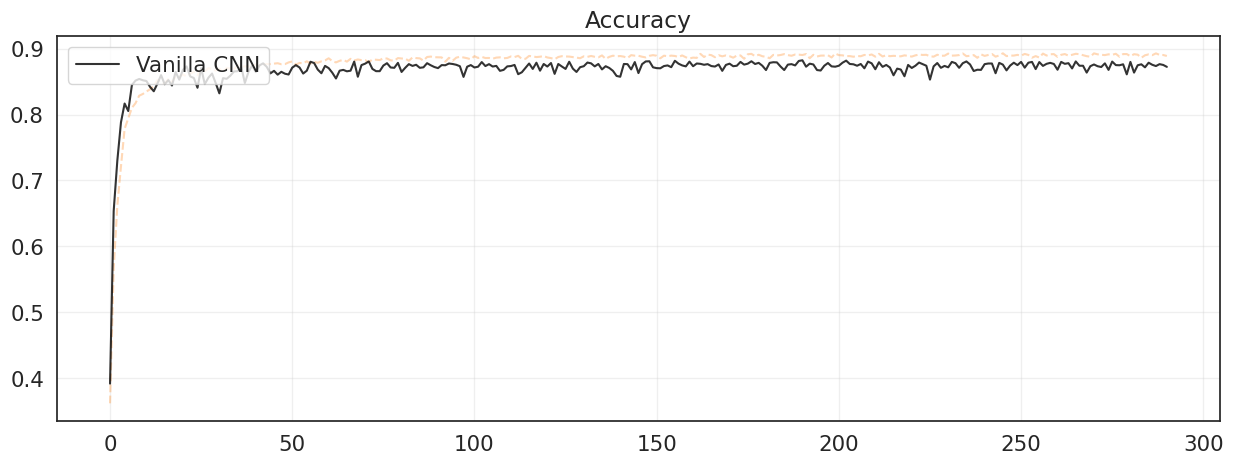

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label='Vanilla CNN', alpha=.8, color='#000000')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

print(round(max(history['accuracy'])* 100, 2))
print(round(max(history['val_accuracy'])* 100, 2))

plt.show()

## 📊 Prepare Your Submission

To prepare your submission, create a `.zip` file that includes all the necessary code to run your model. It **must** include a `model.py` file with the following class:

```python
# file: model.py
class Model:
    def __init__(self):
        """Initialize the internal state of the model."""

    def predict(self, X):
        """Return a numpy array with the labels corresponding to the input X."""
```

The next cell shows an example implementation of the `model.py` file, which includes loading model weights from the `weights.keras` file and conducting predictions on provided input data. The `.zip` file is created and downloaded in the last notebook cell.

❗ Feel free to modify the method implementations to better fit your specific requirements, but please ensure that the class name and method interfaces remain unchanged.

In [ ]:
%%writefile model.py
import numpy as np

import tensorflow as tf
import keras as tfk


class Model:
    def __init__(self):
        """
        Initialize the internal state of the model. Note that the __init__
        method cannot accept any arguments.

        The following is an example loading the weights of a pre-trained
        model.
        """
        self.neural_network = tfk.models.load_model('weights.keras')

    def predict(self, X):
        """
        Predict the labels corresponding to the input X. Note that X is a numpy
        array of shape (n_samples, 96, 96, 3) and the output should be a numpy
        array of shape (n_samples,). Therefore, outputs must no be one-hot
        encoded.

        The following is an example of a prediction from the pre-trained model
        loaded in the __init__ method.
        """
        preds = self.neural_network.predict(X)
        if len(preds.shape) == 2:
            preds = np.argmax(preds, axis=1)
        return preds

Overwriting model.py


In [ ]:
from datetime import datetime
filename = f'submission_{datetime.now().strftime("%y%m%d_%H%M%S")}.zip'

# Add files to the zip command if needed
!zip {filename} model.py weights.keras

  adding: model.py (deflated 55%)
  adding: weights.keras (deflated 13%)
